In [15]:
import numpy as np
from numpy import linalg as LA
from matplotlib import pyplot as plt
import os
import copy

from joint import Joint
from MEMD_all import memd
import bvh
import ht

In [2]:
# check 1
# setting joint
j = Joint()
set_joint = j.left_fore_arm
joint_name = 'left_fore_arm'

# check 2
# setting impact frame
# slice data
'''
select_data = 'slice data'
first_impact = 184
second_impact = 213
third_impact = 187
fourth_impact = 205

'''
# straight data
select_data = 'straight data'
first_impact = 224
second_impact = 186
third_impact = 212
fourth_impact = 228
#'''

print(select_data)

# min_frame -> 一番最小のフレームデータを選択
min_frame = np.array([first_impact, second_impact, third_impact, fourth_impact])
min_frame = np.min(min_frame)
print(min_frame)

# check 3
#setting follor_throught -> インパクトからフォロースルーまでのフレームデータを計算
# slice
#follor_throught = 246 - min_frame

# straight
follor_throught = 260 - min_frame

print(follor_throught)

straight data
186
74


<Figure size 432x288 with 0 Axes>

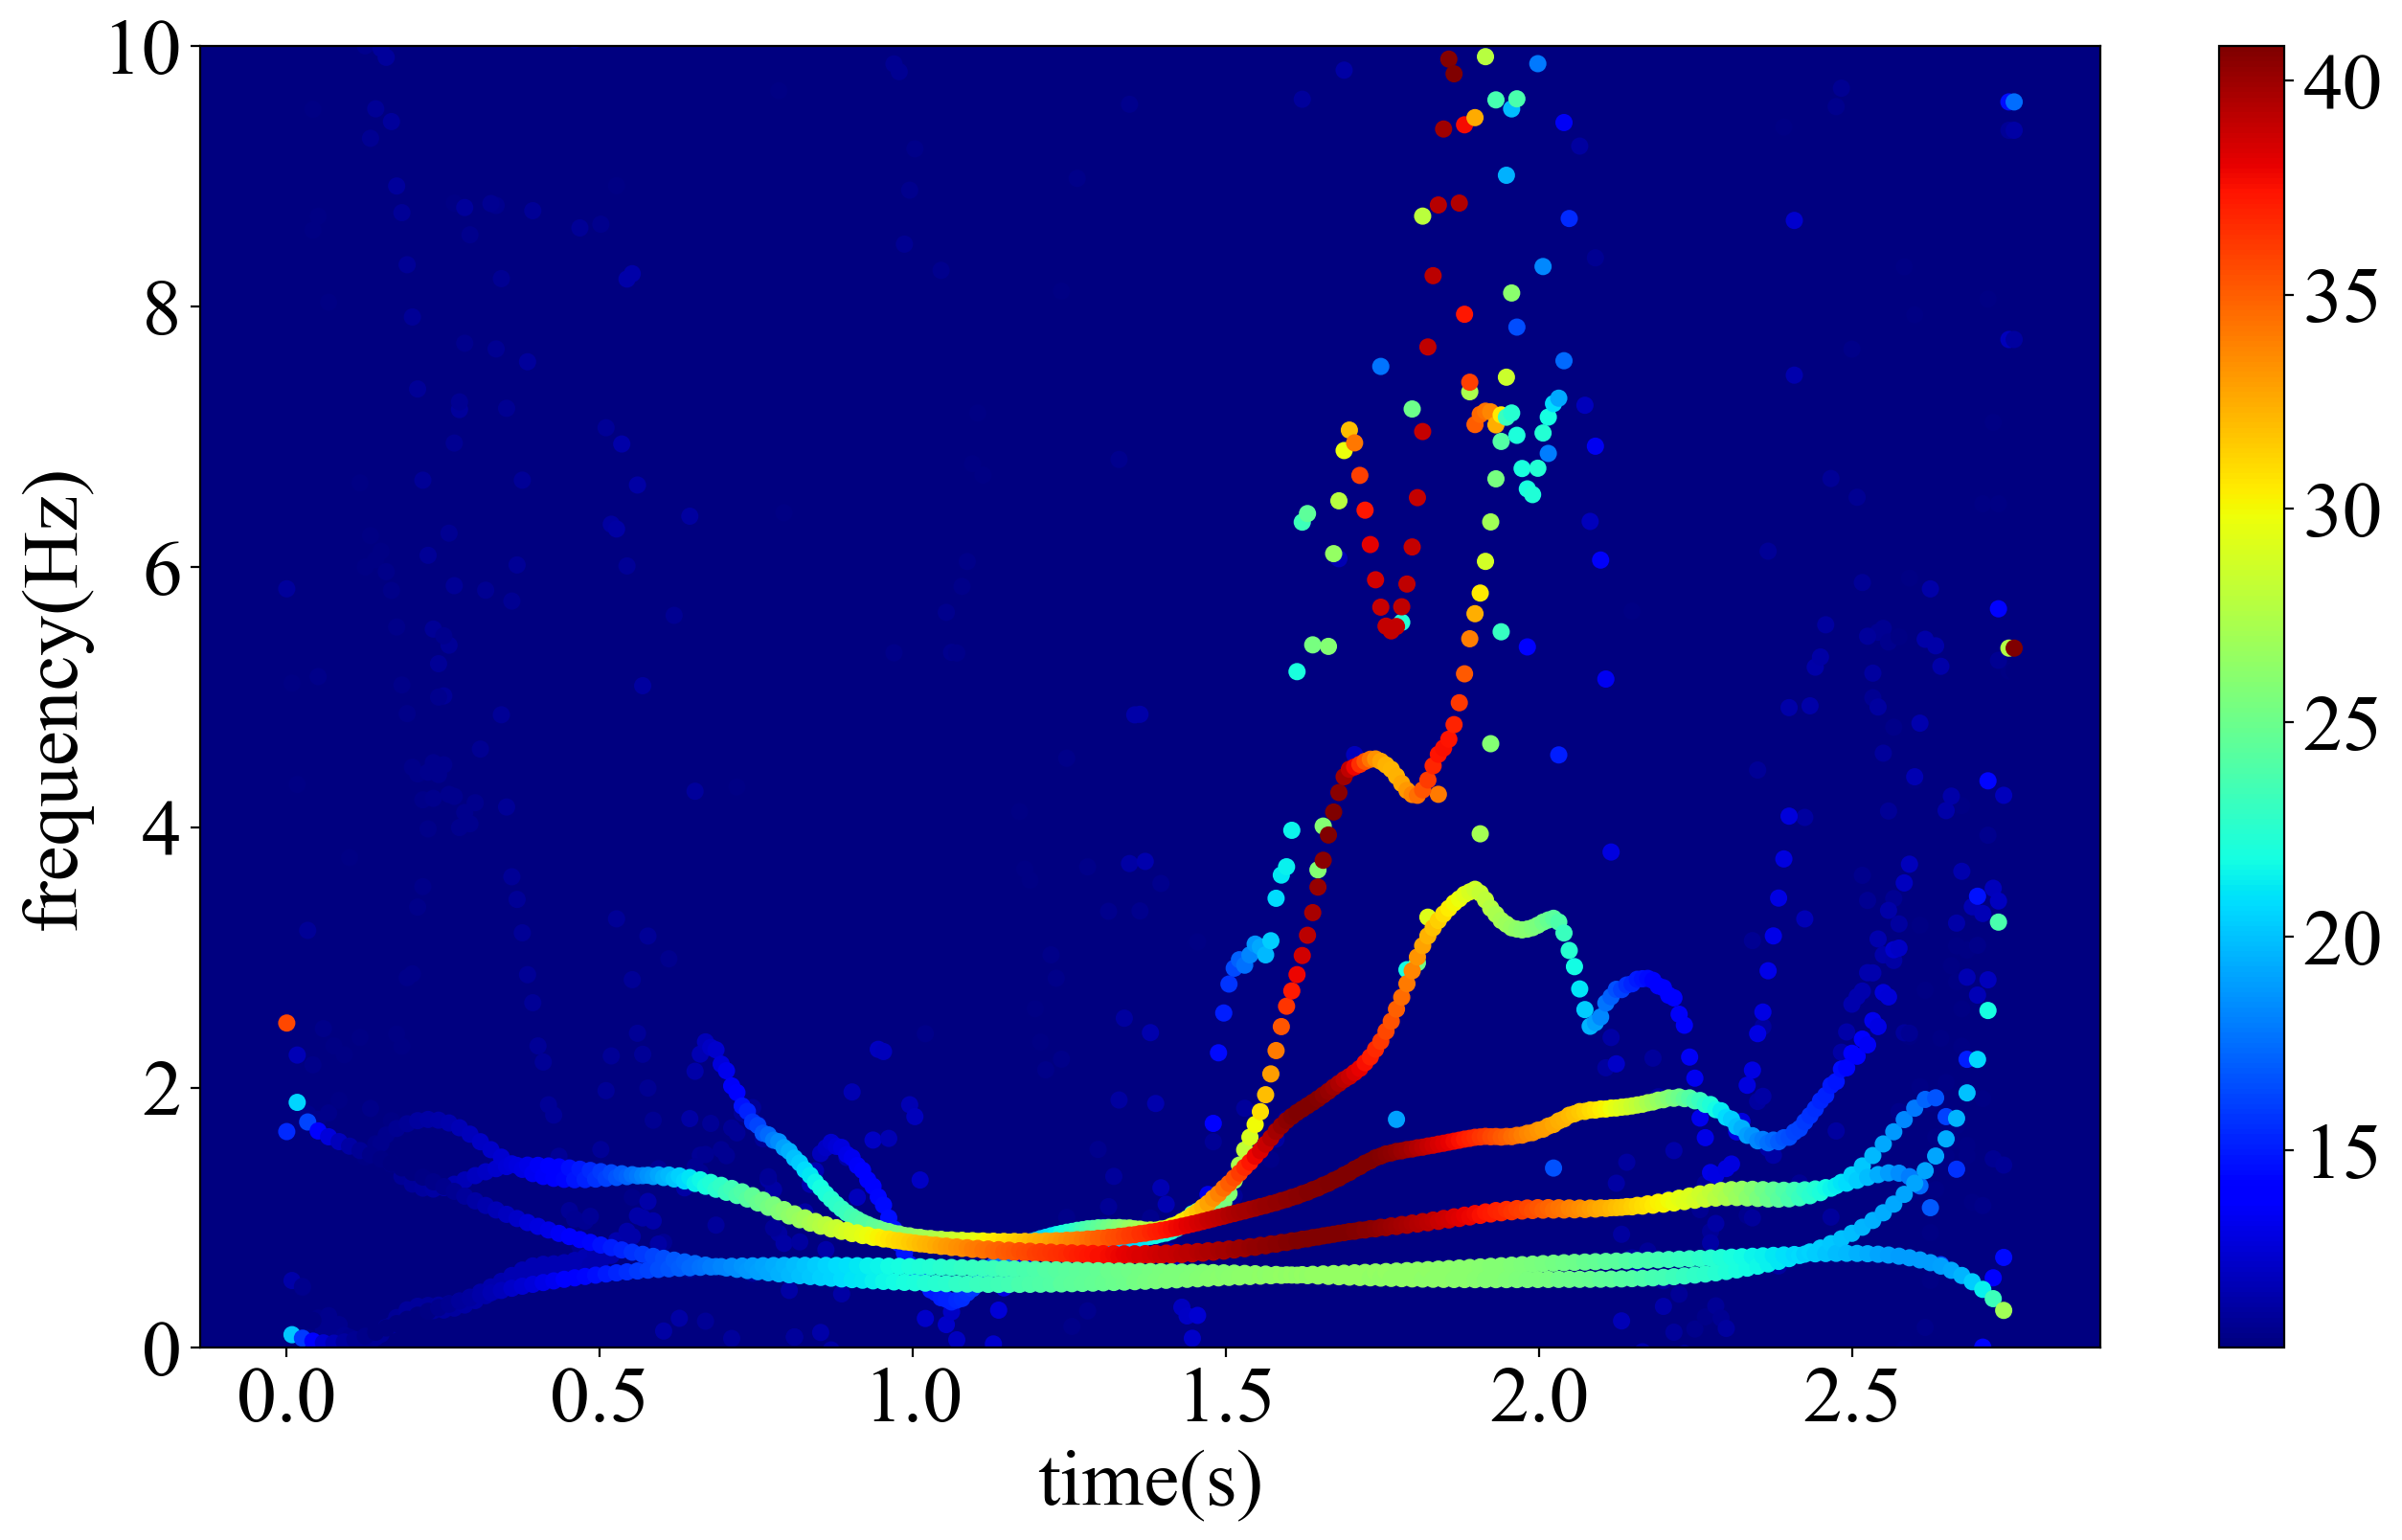

In [3]:
# first straight data
# or
# first slice data
data_path = '../data/1111/straight_data/straight_1_Take_001.bvh'
# data_path = '../data/1111/slice_data/slice_1_Take_001.bvh'

data, fs, text = bvh.bvhreader(data_path)
data = bvh.errc(data, set_joint, set_joint+3)
dt = float(fs)
imf = memd(data)

result_x = imf[:, set_joint, :]
result_z = imf[:, set_joint+1, :]
result_y = imf[:, set_joint+2, :]

# Hilbert Huang Transportation
freq_x, amp_x = ht.FAhilbert(result_x, dt)
freq_z, amp_z = ht.FAhilbert(result_z, dt)
freq_y, amp_y = ht.FAhilbert(result_y, dt)

# freq_x,y,z amp_x,y,z -> 転置
freq_x = freq_x.T
freq_z = freq_z.T
freq_y = freq_y.T

amp_x = amp_x.T
amp_z = amp_z.T
amp_y = amp_y.T

# freq and amp setting
freq_all = np.array([freq_x, freq_z, freq_y])
amp_all = np.array([amp_x, amp_z, amp_y])

# freq means
freq_mean = np.mean(freq_all, axis=0)

# amp normalize
amp_norm = LA.norm(amp_all, axis=0)
# amp_mean = (amp_norm - np.min(amp_norm)) / (np.max(amp_norm) - np.min(amp_norm))

# Number of decomposition
Nod = freq_mean.shape[0]

# frame 
frame = freq_mean.shape[1]

# setting spectrum time
spectrum_time = np.zeros((Nod, frame))
for n in range(Nod):
    spectrum_time[n, :] = np.linspace(0, dt*frame, frame)
    
# spectrogram plot
plt.clf()
plt.figure(dpi = 200, figsize=(16, 9))
plt.rcParams['font.family'] = 'Times new Roman'
plt.rcParams['font.size'] = 30
for n in range(Nod):
    plt.scatter(spectrum_time[n, :], freq_mean[n, :], s = 30, c=amp_norm[n, :frame], cmap='jet')
ax = plt.gca()
ax.set_facecolor([0.0, 0.0, 0.5])
plt.ylim(0, 10)
plt.xlabel('time(s)')
plt.ylabel('frequency(Hz)')
plt.colorbar()
plt.show()

In [4]:
first_freq_data = freq_mean.copy()
first_amp_data = amp_norm.copy()

<Figure size 432x288 with 0 Axes>

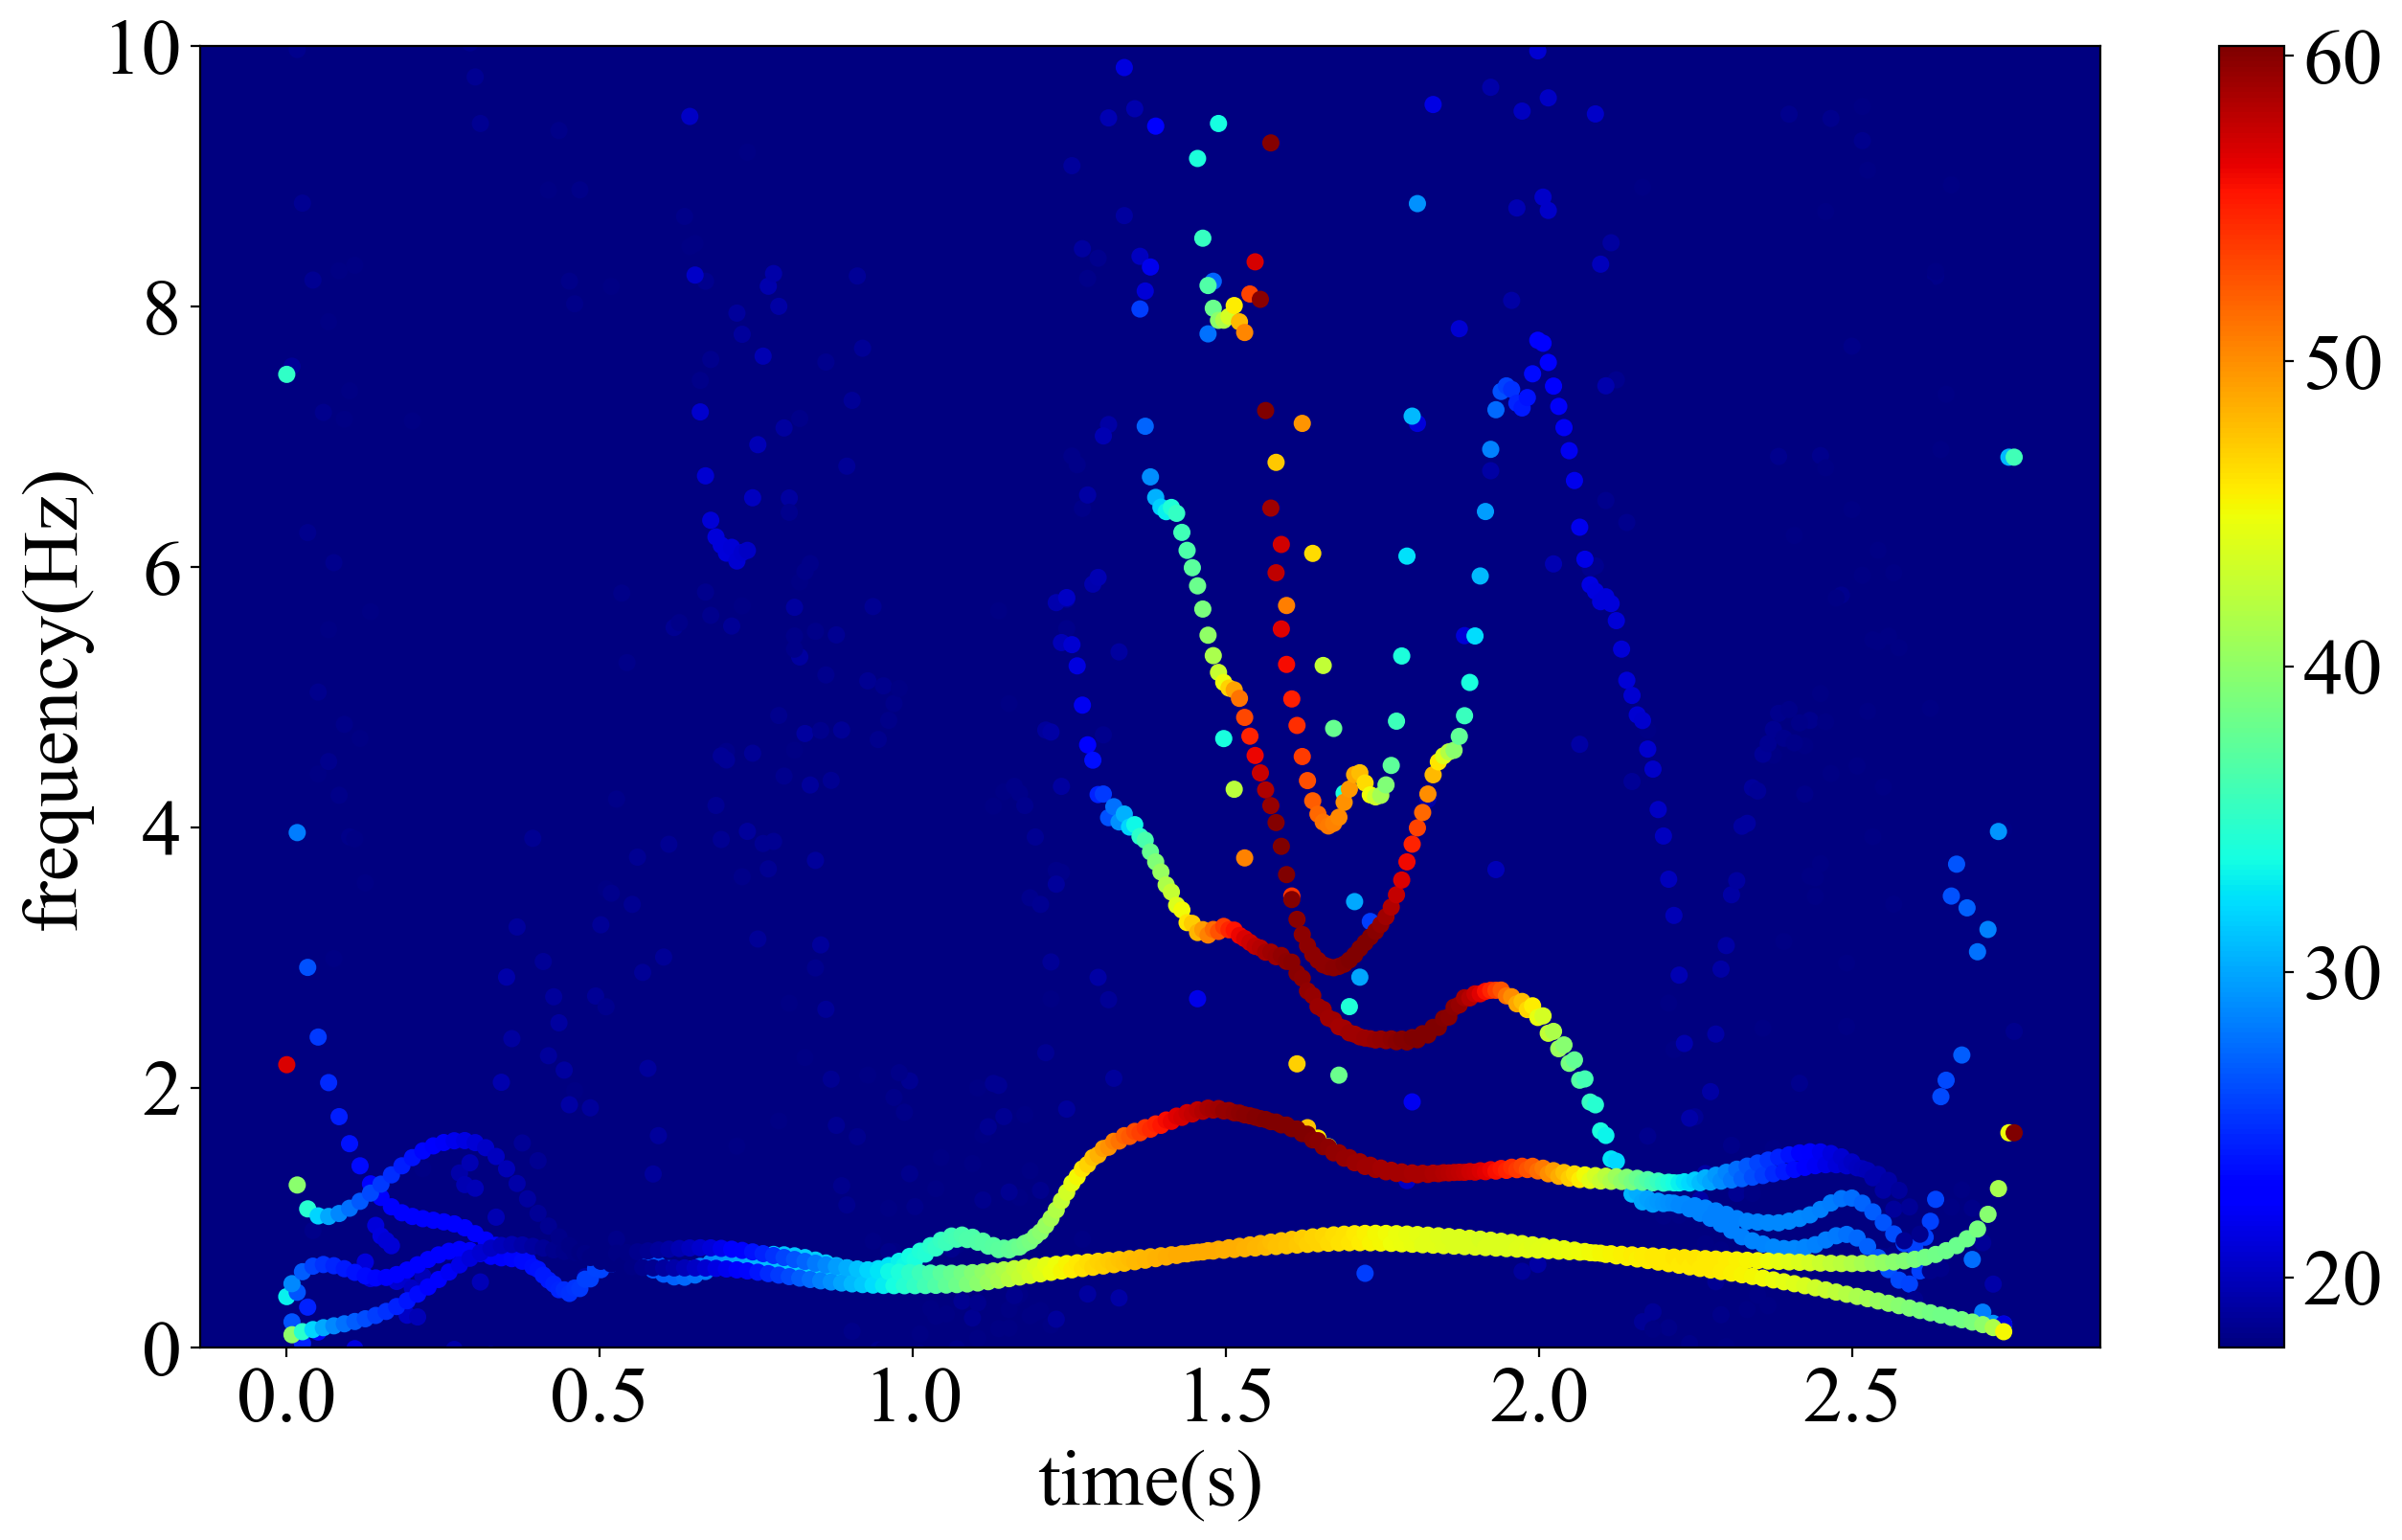

In [5]:
# secont straight data
data_path = '../data/1111/straight_data/straight_2_Take_001.bvh'
# data_path = '../data/1111/slice_data/slice_2_Take_001.bvh'

data, fs, text = bvh.bvhreader(data_path)
data = bvh.errc(data, set_joint, set_joint+3)
dt = float(fs)
imf = memd(data)

result_x = imf[:, set_joint, :]
result_z = imf[:, set_joint+1, :]
result_y = imf[:, set_joint+2, :]

# Hilbert Huang Transportation
freq_x, amp_x = ht.FAhilbert(result_x, dt)
freq_z, amp_z = ht.FAhilbert(result_z, dt)
freq_y, amp_y = ht.FAhilbert(result_y, dt)

# freq_x,y,z amp_x,y,z -> 転置
freq_x = freq_x.T
freq_z = freq_z.T
freq_y = freq_y.T

amp_x = amp_x.T
amp_z = amp_z.T
amp_y = amp_y.T

# freq and amp setting
freq_all = np.array([freq_x, freq_z, freq_y])
amp_all = np.array([amp_x, amp_z, amp_y])

# freq means
freq_mean = np.mean(freq_all, axis=0)

# amp normalize
amp_norm = LA.norm(amp_all, axis=0)
# amp_mean = (amp_norm - np.min(amp_norm)) / (np.max(amp_norm) - np.min(amp_norm))

# Number of decomposition
Nod = freq_mean.shape[0]

# frame 
frame = freq_mean.shape[1]

# setting spectrum time
spectrum_time = np.zeros((Nod, frame))
for n in range(Nod):
    spectrum_time[n, :] = np.linspace(0, dt*frame, frame)
    
# spectrogram plot
plt.clf()
plt.figure(dpi = 200, figsize=(16, 9))
plt.rcParams['font.family'] = 'Times new Roman'
plt.rcParams['font.size'] = 30
for n in range(Nod):
    plt.scatter(spectrum_time[n, :], freq_mean[n, :], s = 30, c=amp_norm[n, :frame], cmap='jet')
ax = plt.gca()
ax.set_facecolor([0.0, 0.0, 0.5])
plt.ylim(0, 10)
plt.xlabel('time(s)')
plt.ylabel('frequency(Hz)')
plt.colorbar()
plt.show()

In [6]:
second_freq_data = freq_mean.copy()
second_amp_data = amp_norm.copy()

<Figure size 432x288 with 0 Axes>

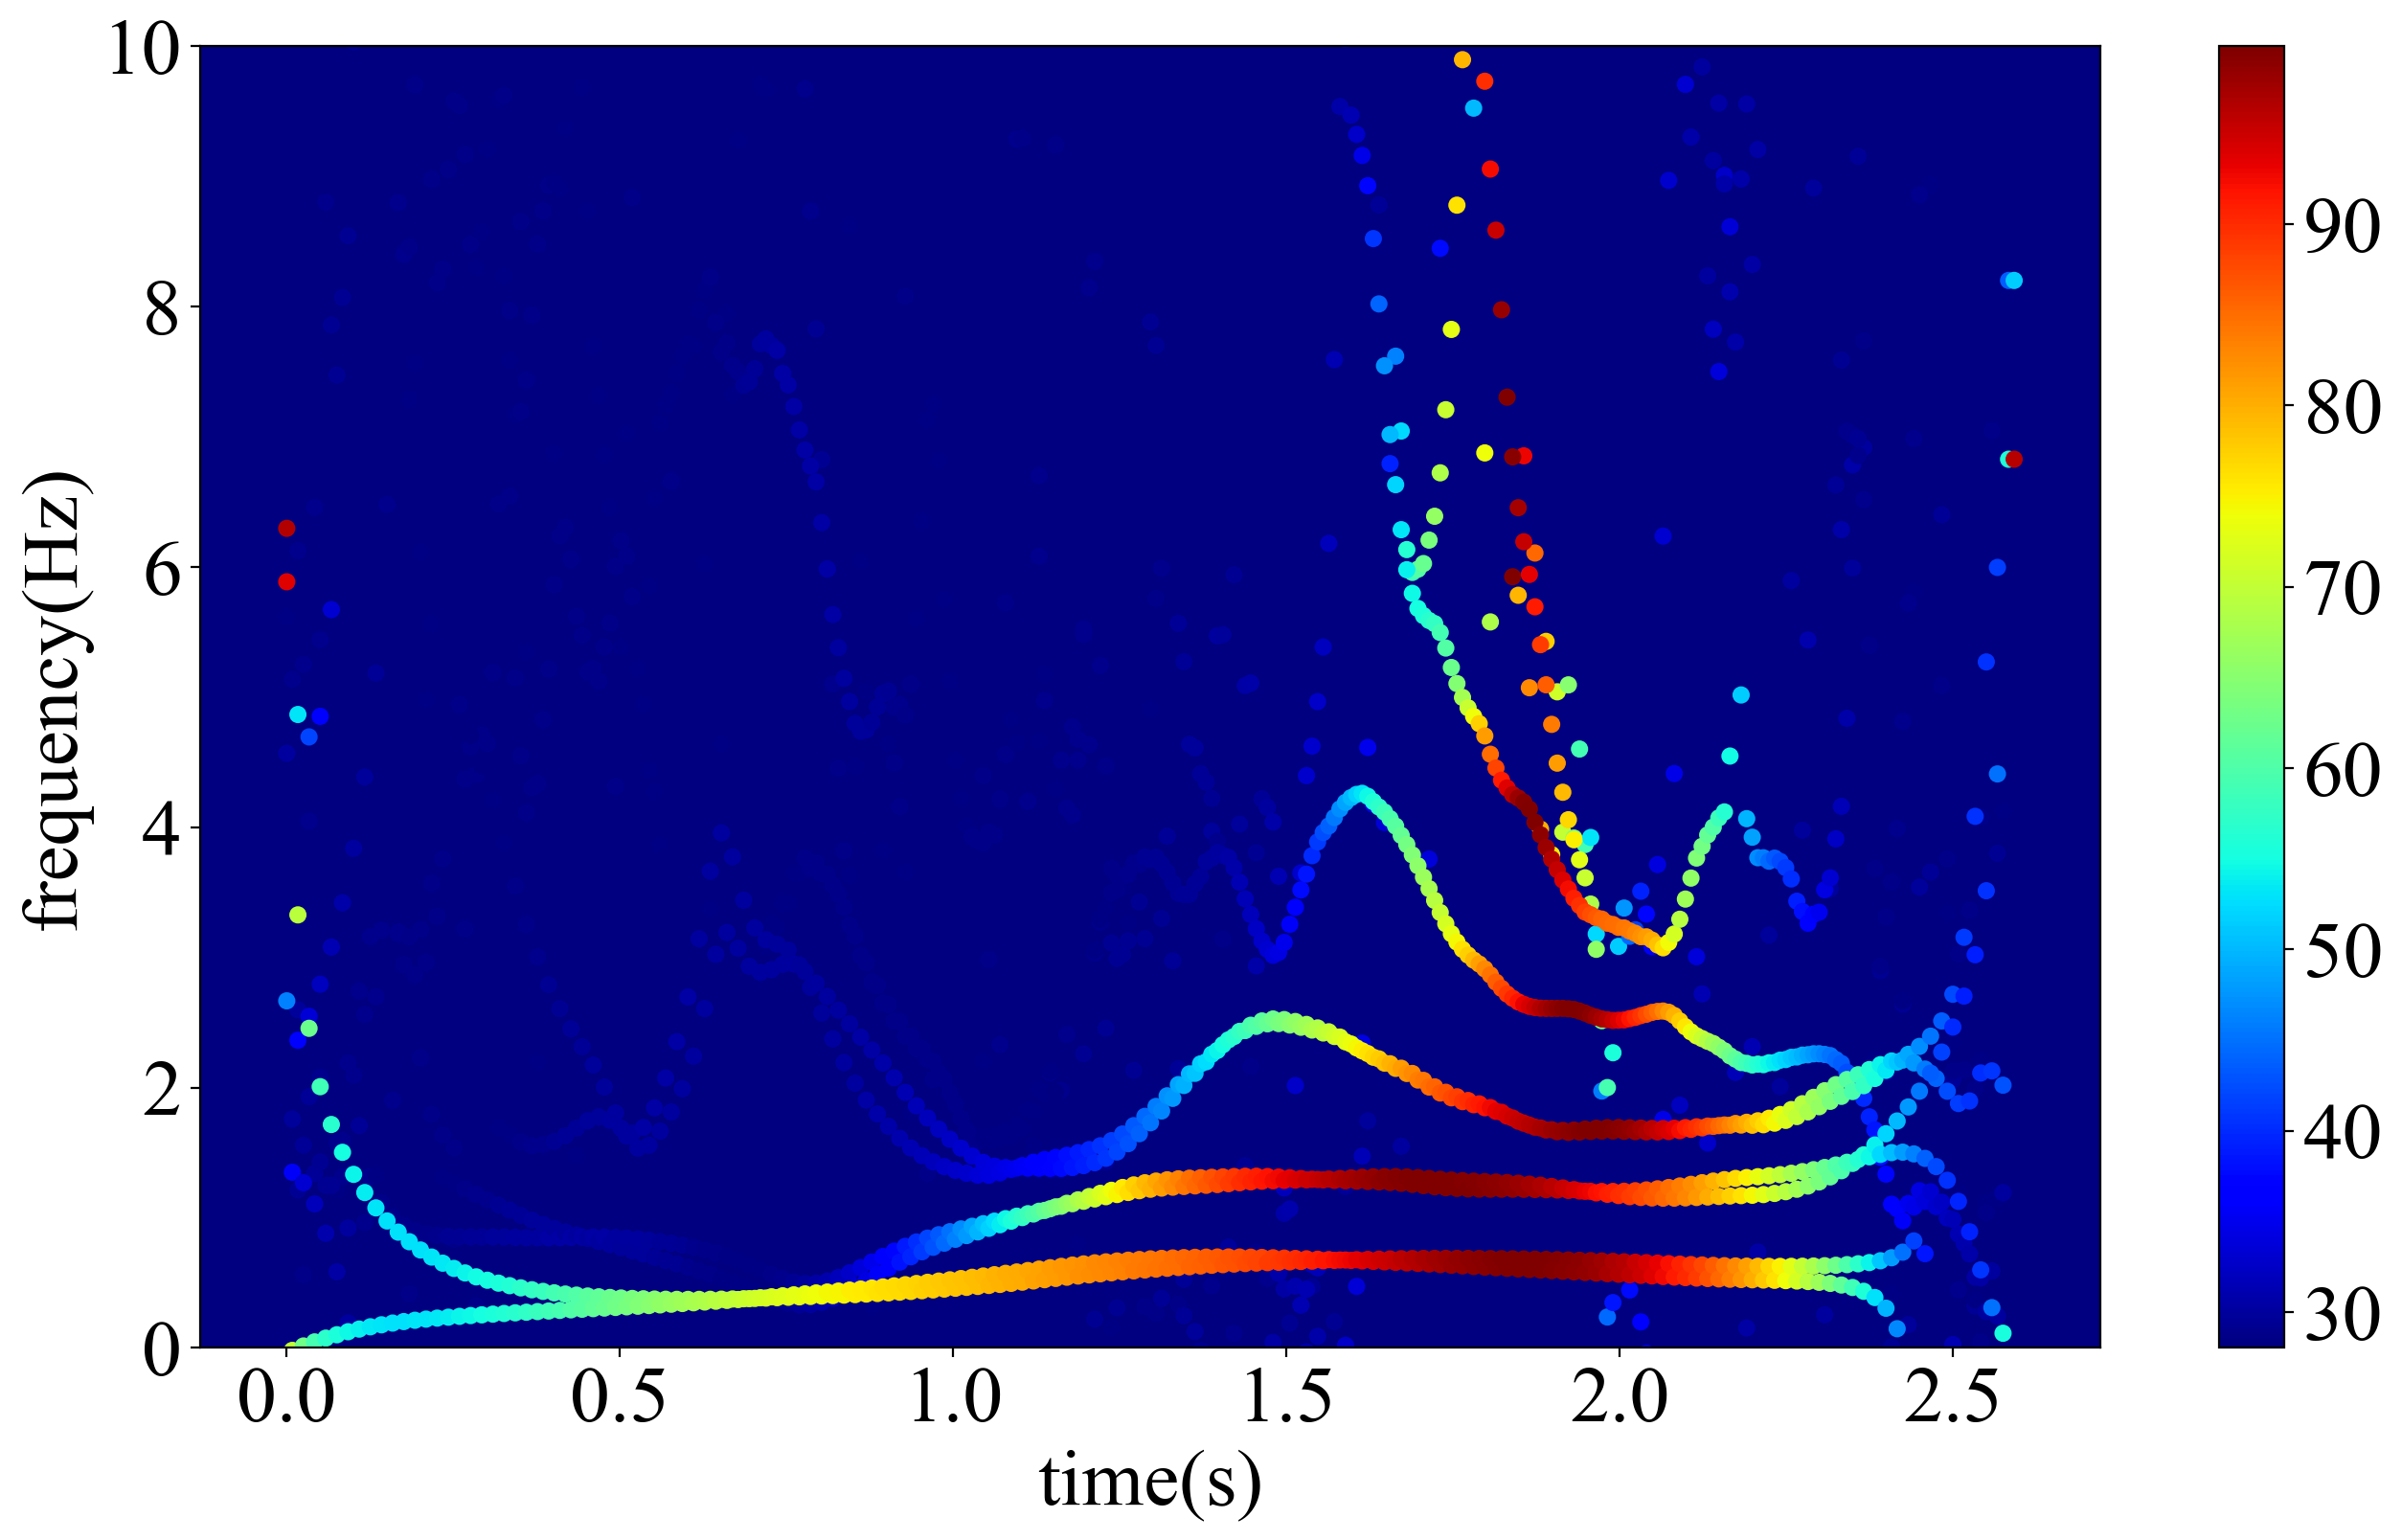

In [7]:
# third straight data
data_path = '../data/1111/straight_data/straight_3_Take_001.bvh'
# data_path = '../data/1111/slice_data/slice_3_Take_001.bvh'

data, fs, text = bvh.bvhreader(data_path)
data = bvh.errc(data, set_joint, set_joint+3)
dt = float(fs)
imf = memd(data)

result_x = imf[:, set_joint, :]
result_z = imf[:, set_joint+1, :]
result_y = imf[:, set_joint+2, :]

# Hilbert Huang Transportation
freq_x, amp_x = ht.FAhilbert(result_x, dt)
freq_z, amp_z = ht.FAhilbert(result_z, dt)
freq_y, amp_y = ht.FAhilbert(result_y, dt)

# freq_x,y,z amp_x,y,z -> 転置
freq_x = freq_x.T
freq_z = freq_z.T
freq_y = freq_y.T

amp_x = amp_x.T
amp_z = amp_z.T
amp_y = amp_y.T

# freq and amp setting
freq_all = np.array([freq_x, freq_z, freq_y])
amp_all = np.array([amp_x, amp_z, amp_y])

# freq means
freq_mean = np.mean(freq_all, axis=0)

# amp normalize
amp_norm = LA.norm(amp_all, axis=0)
# amp_mean = (amp_norm - np.min(amp_norm)) / (np.max(amp_norm) - np.min(amp_norm))

# Number of decomposition
Nod = freq_mean.shape[0]

# frame 
frame = freq_mean.shape[1]

# setting spectrum time
spectrum_time = np.zeros((Nod, frame))
for n in range(Nod):
    spectrum_time[n, :] = np.linspace(0, dt*frame, frame)
    
# spectrogram plot
plt.clf()
plt.figure(dpi = 200, figsize=(16, 9))
plt.rcParams['font.family'] = 'Times new Roman'
plt.rcParams['font.size'] = 30
for n in range(Nod):
    plt.scatter(spectrum_time[n, :], freq_mean[n, :], s = 30, c=amp_norm[n, :frame], cmap='jet')
ax = plt.gca()
ax.set_facecolor([0.0, 0.0, 0.5])
plt.ylim(0, 10)
plt.xlabel('time(s)')
plt.ylabel('frequency(Hz)')
plt.colorbar()
plt.show()

In [8]:
third_freq_data = freq_mean.copy()
third_amp_data = amp_norm.copy()

<Figure size 432x288 with 0 Axes>

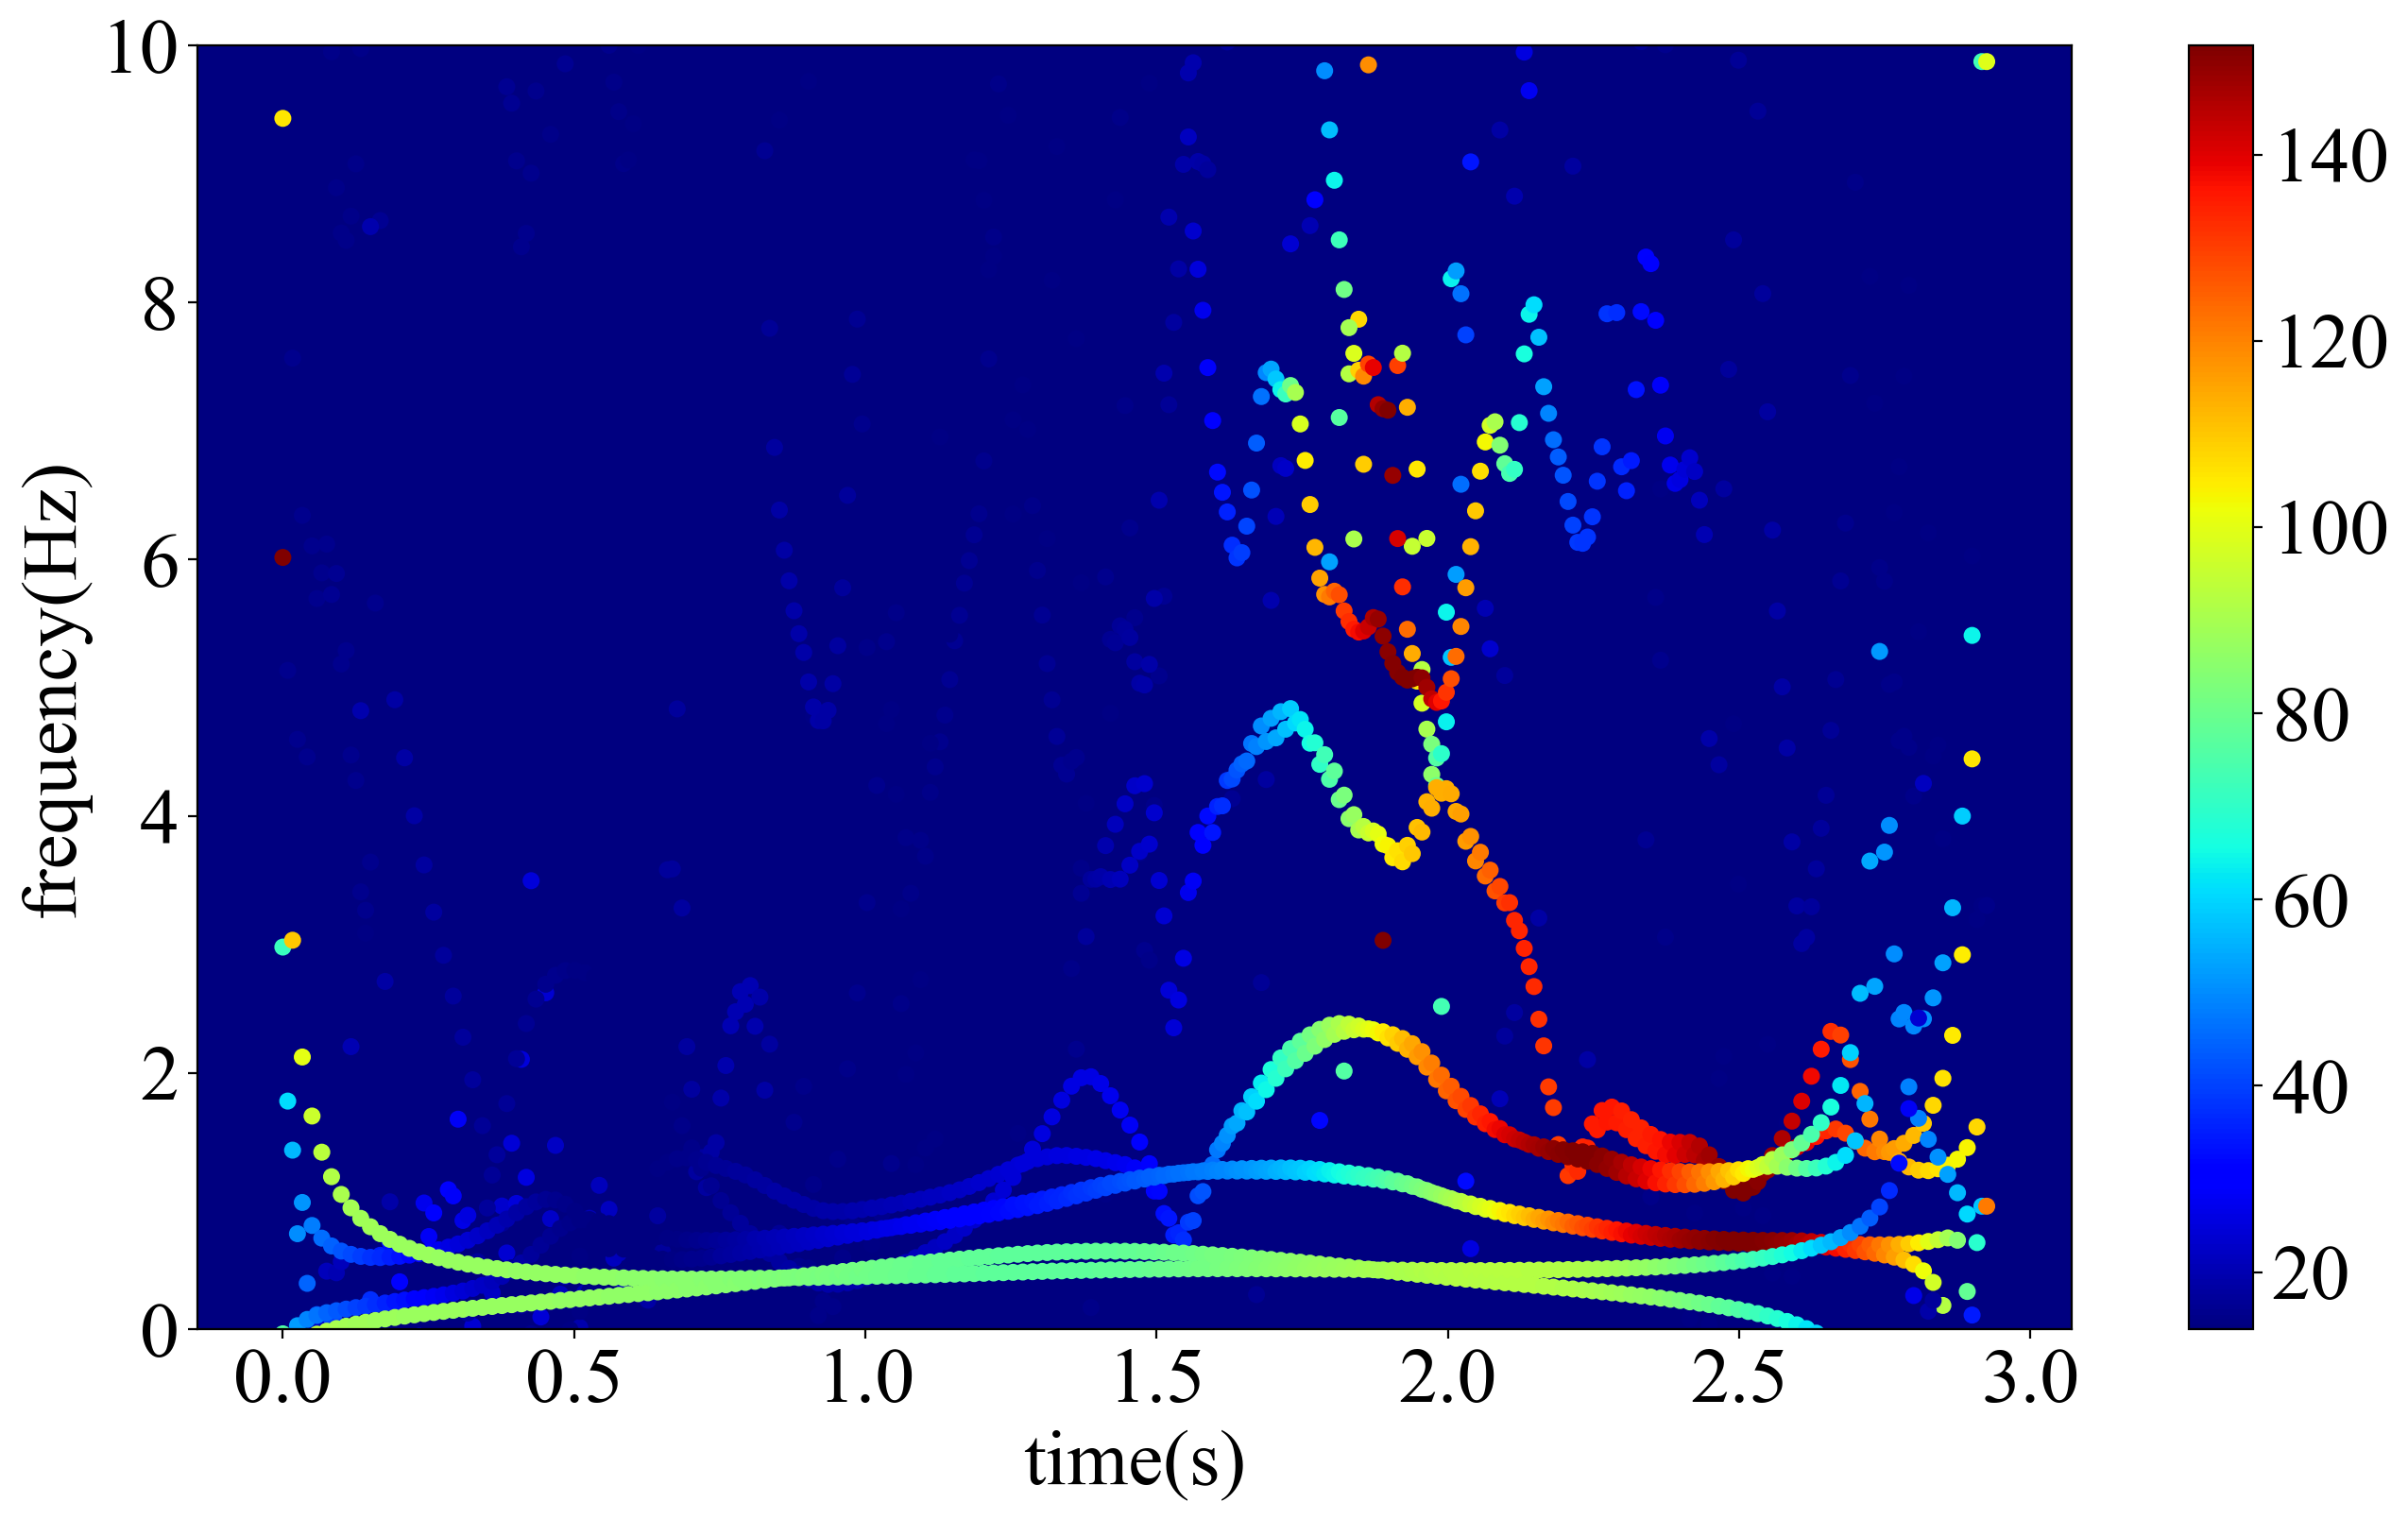

In [9]:
# fourth straight data
data_path = '../data/1111/straight_data/straight_4_Take_001.bvh'
# data_path = '../data/1111/slice_data/slice_4_Take_001.bvh'

data, fs, text = bvh.bvhreader(data_path)
data = bvh.errc(data, set_joint, set_joint+3)
dt = float(fs)
imf = memd(data)

result_x = imf[:, set_joint, :]
result_z = imf[:, set_joint+1, :]
result_y = imf[:, set_joint+2, :]

# Hilbert Huang Transportation
freq_x, amp_x = ht.FAhilbert(result_x, dt)
freq_z, amp_z = ht.FAhilbert(result_z, dt)
freq_y, amp_y = ht.FAhilbert(result_y, dt)

# freq_x,y,z amp_x,y,z -> 転置
freq_x = freq_x.T
freq_z = freq_z.T
freq_y = freq_y.T

amp_x = amp_x.T
amp_z = amp_z.T
amp_y = amp_y.T

# freq and amp setting
freq_all = np.array([freq_x, freq_z, freq_y])
amp_all = np.array([amp_x, amp_z, amp_y])

# freq means
freq_mean = np.mean(freq_all, axis=0)

# amp normalize
amp_norm = LA.norm(amp_all, axis=0)
# amp_mean = (amp_norm - np.min(amp_norm)) / (np.max(amp_norm) - np.min(amp_norm))

# Number of decomposition
Nod = freq_mean.shape[0]

# frame 
frame = freq_mean.shape[1]

# setting spectrum time
spectrum_time = np.zeros((Nod, frame))
for n in range(Nod):
    spectrum_time[n, :] = np.linspace(0, dt*frame, frame)
    
# spectrogram plot
plt.clf()
plt.figure(dpi = 200, figsize=(16, 9))
plt.rcParams['font.family'] = 'Times new Roman'
plt.rcParams['font.size'] = 30
for n in range(Nod):
    plt.scatter(spectrum_time[n, :], freq_mean[n, :], s = 30, c=amp_norm[n, :frame], cmap='jet')
ax = plt.gca()
ax.set_facecolor([0.0, 0.0, 0.5])
plt.ylim(0, 10)
plt.xlabel('time(s)')
plt.ylabel('frequency(Hz)')
plt.colorbar()
plt.show()

In [10]:
fourth_freq_data = freq_mean.copy()
fourth_amp_data = amp_norm.copy()

In [11]:
print(first_freq_data.shape)
print(second_freq_data.shape)
print(third_freq_data.shape)
print(fourth_freq_data.shape)

(7, 331)
(6, 331)
(7, 311)
(7, 351)


In [12]:
# setting frame data
first_freq_data = first_freq_data[:6, first_impact - min_frame : first_impact + follor_throught]
first_amp_data = first_amp_data[:6, first_impact - min_frame : first_impact + follor_throught]

second_freq_data = second_freq_data[:6, second_impact - min_frame : second_impact + follor_throught]
second_amp_data = second_amp_data[:6, second_impact - min_frame : second_impact + follor_throught]

third_freq_data = third_freq_data[:6, third_impact - min_frame : third_impact + follor_throught]
third_amp_data = third_amp_data[:6, third_impact - min_frame : third_impact + follor_throught]

fourth_freq_data = fourth_freq_data[:6, fourth_impact - min_frame : fourth_impact + follor_throught]
fourth_amp_data = fourth_amp_data[:6, fourth_impact - min_frame : fourth_impact + follor_throught]

# all data means or norm
all_freq_data = (first_freq_data + second_freq_data + third_freq_data + fourth_freq_data) / 4
all_amp_data = (first_amp_data + second_amp_data + third_amp_data + fourth_amp_data) / 4
all_amp_data = (all_amp_data - np.min(all_amp_data)) / (np.max(all_amp_data) - np.min(all_amp_data))

# Number of decomposition
Nod = all_freq_data.shape[0]
#frame 
frame = all_freq_data.shape[1]

# setting spectrum time
spectrum_time = np.zeros((Nod, frame))
for n in range(Nod):
    spectrum_time[n, :] = np.linspace(0, dt*frame, frame)
print(spectrum_time.shape)

(6, 260)


straight data
left_fore_arm


<Figure size 432x288 with 0 Axes>

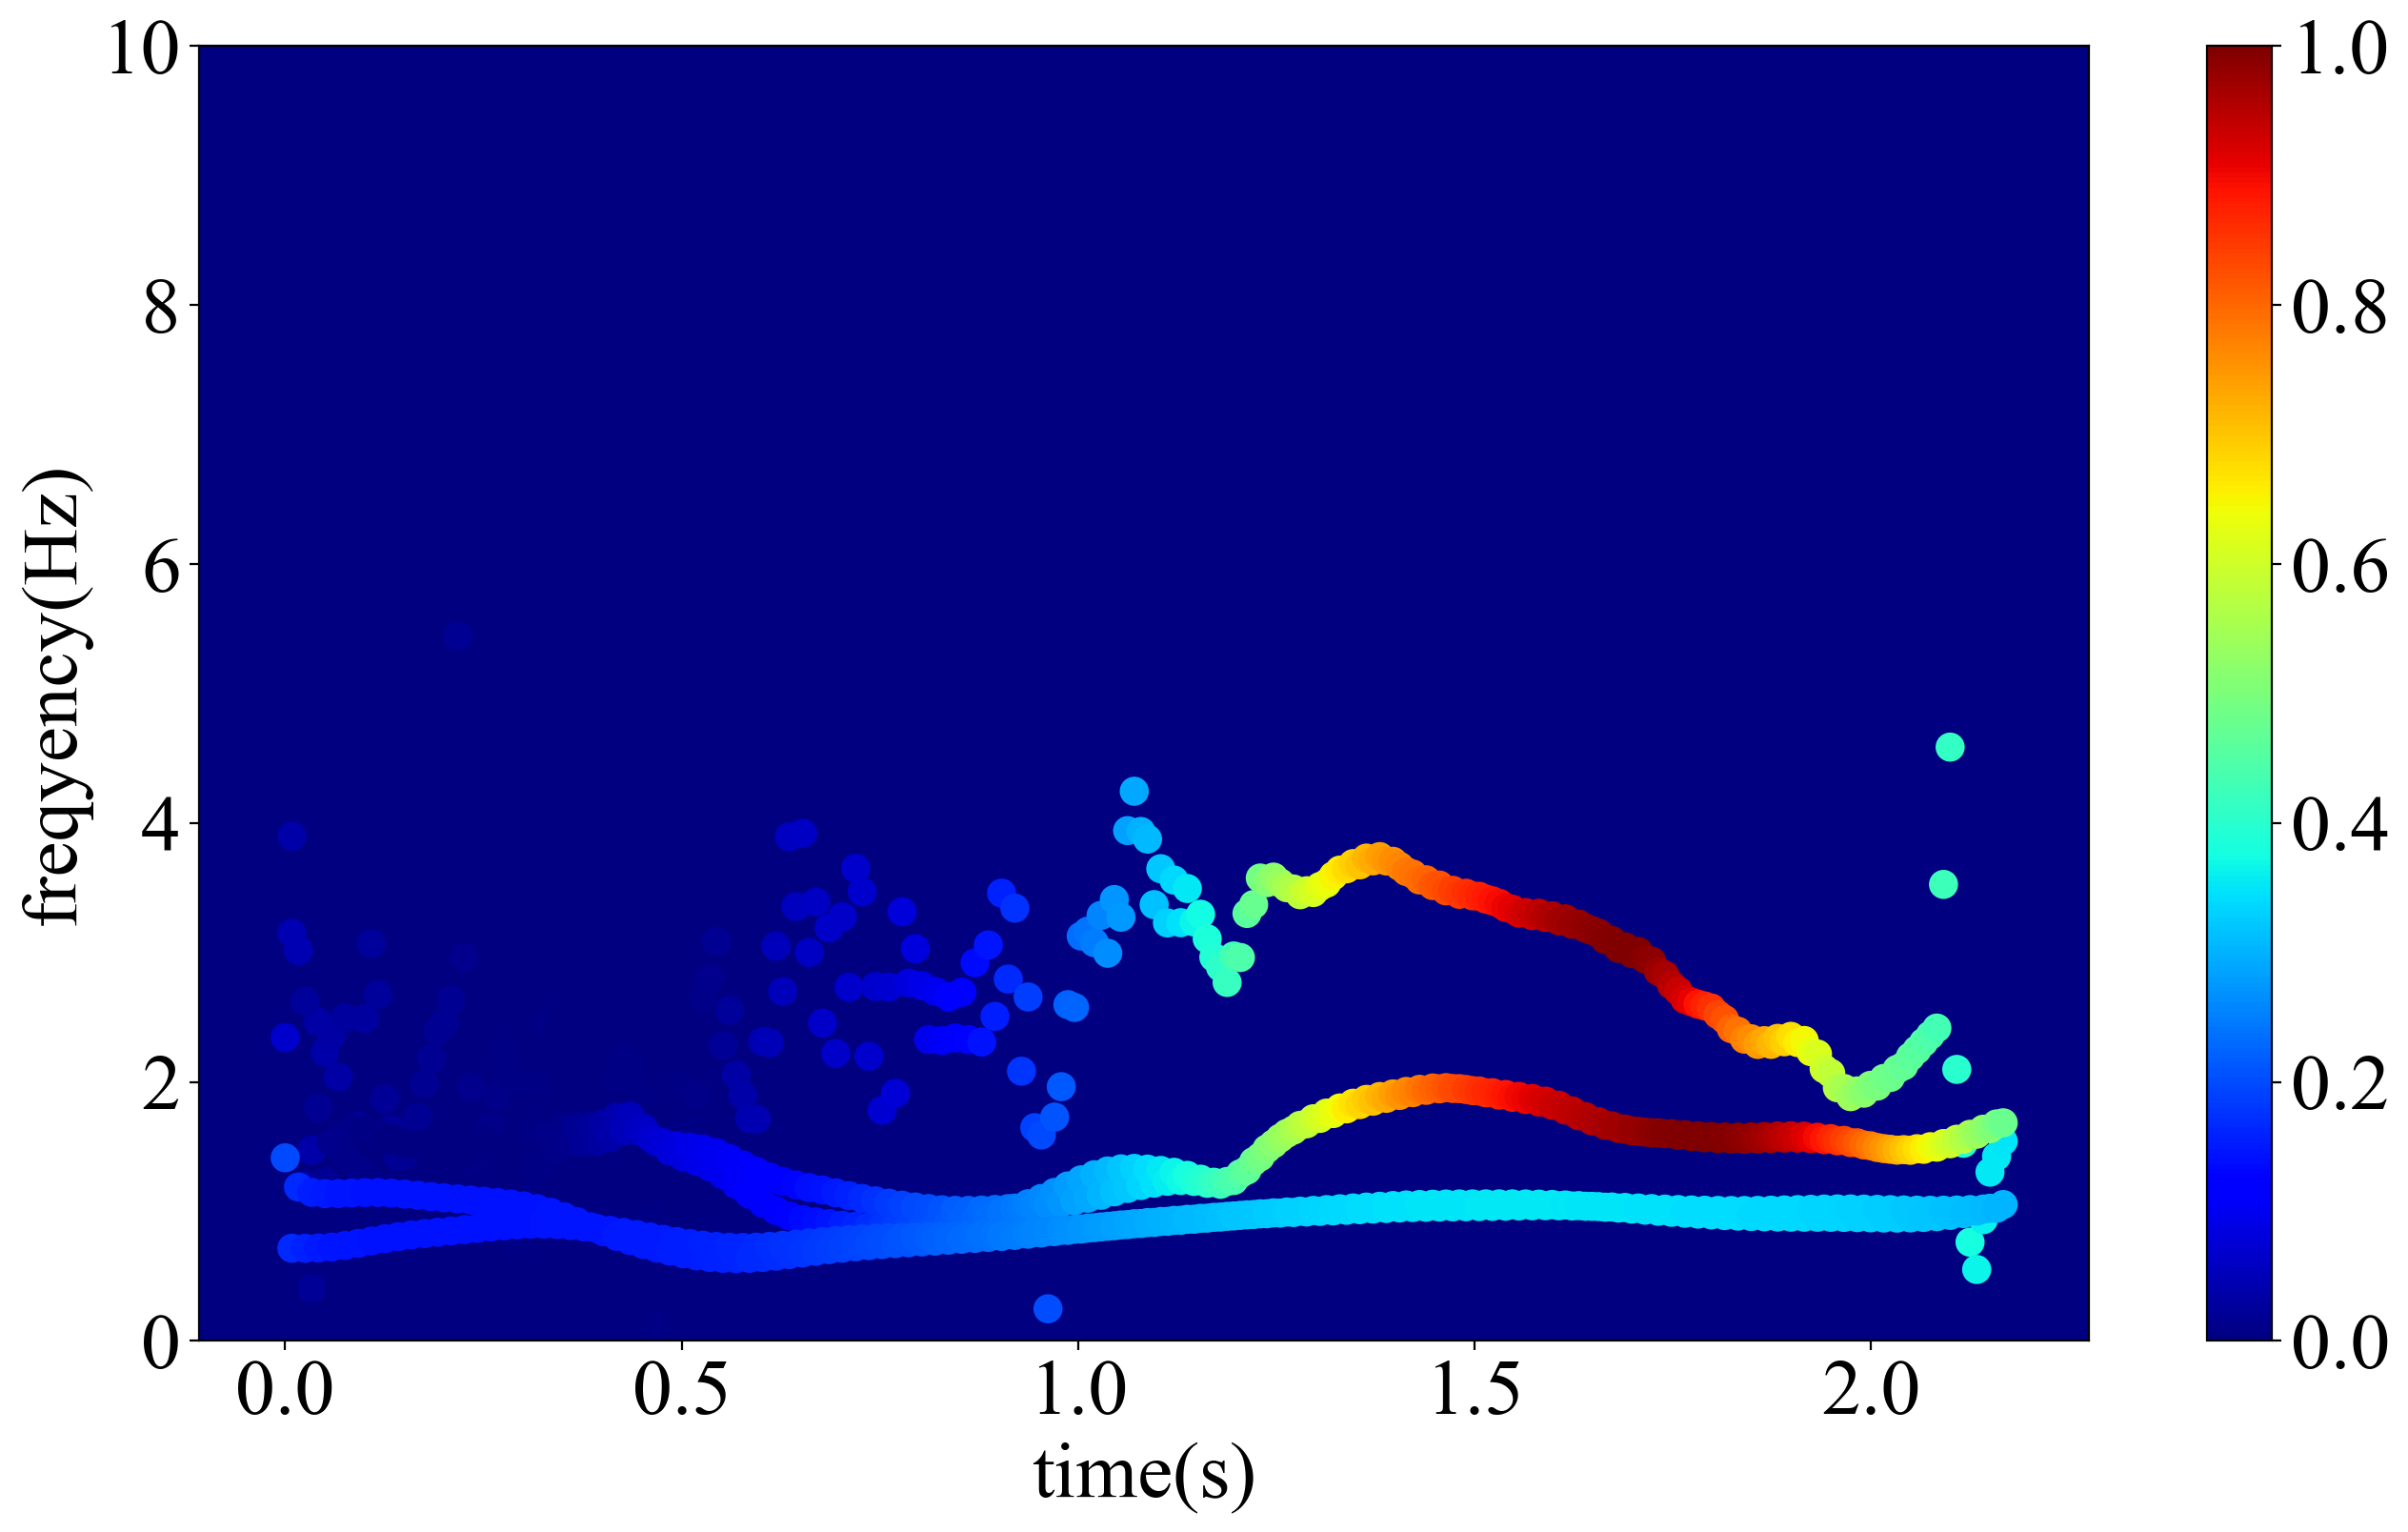

In [14]:
print(select_data)
print(joint_name)
# spectrogram plot
plt.clf()
plt.figure(dpi = 200, figsize=(16, 9))
plt.rcParams['font.family'] = 'Times new Roman'
plt.rcParams['font.size'] = 30
for n in range(3, Nod):
    plt.scatter(spectrum_time[n, :], all_freq_data[n, :], s = 100, c=all_amp_data[n, :frame], cmap='jet')
ax = plt.gca()
ax.set_facecolor([0.0, 0.0, 0.5])
plt.ylim(0, 10)
plt.xlabel('time(s)')
plt.ylabel('freqyency(Hz)')
plt.colorbar()
plt.clim(0,1)
plt.savefig('slice_data')
plt.show()